# L3a: Linear regression models for prediction and classification tasks
This lecture explores linear regression models for prediction and classification. Linear regression predicts continuous target variables using one or more features (prediction) and classifies objects based on features (classification). These models are easy to implement and interpret, serving as a foundation for more complex predictive analytics algorithms.

There are several key ideas in this lecture:

* __Linear regression__ is a statistical method for modeling the relationship between a dependent variable (target) and one or more independent variables (features) by fitting a linear equation to observed data. It provides a simple way to predict outcomes and understand relationships between variables.
* __Continuous variable__ prediction tasks: In machine learning, linear regression models are commonly employed for continuous variable prediction tasks. These models enable the estimation of numerical outcomes based on the (non)linear relationships identified between input features and the target variable.
* __Classification tasks__: While linear regression is primarily designed to predict continuous outcomes, it can also be adapted for classification tasks by combining the linear regression model with an output function that transforms the continuous target variable predictions into discrete classes or probability estimates. In this lecture, we'll consider binary classification using [the perceptron classification algorithm, developed at Cornell in the 1950s](https://en.wikipedia.org/wiki/Perceptron).

### Setup, Data and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl")

## Linear regression models for continuous prediction tasks
Suppose there exists a dataset $\mathcal{D} = \left\{\mathbf{x}_{i},y_{i}\right\}_{i=1}^{n}$ with $n$-training (labeled) examples, where $\mathbf{x}_{i}\in\mathbb{R}^{p}$ is a $p$-vector of features (independent variables, typically real but potentially complex as well) and $y_{i}\in\mathbb{R}$ denotes a scalar response variable (dependent variable). Then, a $\texttt{linear regression model}$ for the dataset $\mathcal{D}$ takes the form:
$$
\begin{equation*}
y_{i} = \mathbf{x}_{i}^{T}\cdot\mathbf{\beta} + \epsilon_{i}\qquad{i=1,2,\dots,n}
\end{equation*}
$$
where $\mathbf{\beta}\in\mathbb{R}^{p}$ is a $p\times{1}$ vector of unknown model parameters, and $\epsilon_{i}\in\mathbb{R}$ is the unobserved random error for response $i$. The linear regression model in matrix-vector form is given by:
$$
\begin{equation*}
\mathbf{y} = \mathbf{X}\cdot\mathbf{\beta} + \mathbf{\epsilon}
\end{equation*}
$$
where $\mathbf{X}$ is an $n\times{p}$ matrix with the features $\mathbf{x}_{i}^{T}$ on the rows, 
the response vector $\mathbf{y}$ is an $n\times{1}$ vector with entries $y_{i}$, 
and the error vector $\mathbf{\epsilon}$ is an $n\times{1}$ vector with entries $\epsilon_{i}$. The challenge of linear regression is to estimate the unknown parameters $\mathbf{\beta}$ from the dataset $\mathcal{D}$.

### Case I: Overdetermined data matrix
Let the data matrix $\mathbf{X}$ be $\texttt{overdetermined}$, i.e., $n > p$ (more rows than columns), and the error vector $\mathbf{\epsilon}\sim\mathcal{N}(\mathbf{0},\sigma^{2}\cdot\mathbf{I})$.
Then, the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimate of the unknown parameters $\mathbf{\beta}$ will $\textit{minimize}$ the sum of squared errors between model estimates and observed values:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} ||~\mathbf{y} - \mathbf{X}\cdot\mathbf{\beta}~||^{2}_{2}
\end{equation*}
$$
where $||\star||^{2}_{2}$ is the square of the [`p = 2` vector norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm), and $\hat{\mathbf{\beta}}$ denotes the estimated parameter vector.  The parameters $\hat{\mathbf{\beta}}$ that minimize the $||\star||^{2}_{2}$ loss for an overdetermined data matrix $\mathbf{X}$ are given by:
\begin{equation*}
\hat{\mathbf{\beta}} = \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}\mathbf{y} - \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}\mathbf{\epsilon}
\end{equation*}
The matrix $\mathbf{X}^{T}\mathbf{X}$ is the $\texttt{normal matrix}$, while $\mathbf{X}^{T}\mathbf{y}$ is the $\texttt{moment vector}$. The inverse $\left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}$ must exist to obtain the estimated model parameter vectors $\hat{\mathbf{\beta}}$.

#### Example: Lineweaver–Burk plot
Suppose we have an enzyme-catalyzed conversion of substrate $S$ to the product $P$ under the action of enzyme $E$. The rate of this reaction $r$ can be described using [Michaelis–Menten kinetics](https://en.wikipedia.org/wiki/Michaelis–Menten_kinetics), which we can linearize by taking the inverse:
$$
\begin{equation}
\frac{1}{r} = \left(\frac{K}{\mu\cdot{E}}\right)\cdot\left(\frac{1}{S}\right) + \frac{1}{\mu\cdot{E}}
\end{equation}
$$
where $K$ denotes the saturation constant, $\mu$ denotes the catalytic rate constant, $S$ denotes the substrate concentration, and $E$ denotes the enzyme concentration. This is a linear expression where the dependent variable is the inverse rate, and the independent variable is the inverse substrate concentration. We have two parameters to estimate: the saturation constant $K$ and the catalytic rate constant $\mu$. 
* __Scenario__: Suppose we did multiple measurements of the rate $r$ as a function of the (initial) substrate concentration for several enzyme levels. Let's see how we could estimate (and test) the kinetic parameters from the data. This will be an overdetermined case: more measurements (rows) and then unknown parameters (columns).

In [7]:
synthetic_experimental_data = let

    # Chymotrypsin actual parameters (only the oracle knows these), and experimental setup
    number_of_substrate_samples = 100; # how many substrate samples will we measure?
    number_of_enzyme_samples = 10; # how many enzyme concentrations will we measure?
    number_of_replicates = 10; # how many estimates do we take per condition?
    μ = 0.14*60; # units 1/min
    K = 15.0; # units mM
    E = range(0.01, stop=0.1,length=number_of_enzyme_samples) |> collect; # true: set of enzyme concentrations we'll explore (units: mM)
    S = range(0.1, stop=3*K, length = number_of_substrate_samples) |> collect; # true: set of substate concentrations we'll explore (units: mM)
    σ₁ = 0.001*K; # uncertainty in the substrate measurement
    σ₂ = 0.01*μ; # uncertainty in the rate measurement
    σ₃ = 0.001*mean(E); # uncertainty in the enzyme measurement

    d₁ = Normal(0,σ₁); # measurement error substrate
    d₂ = Normal(0,σ₂); # measurement error rate
    d₃ = Normal(0,σ₃); # measurement error enzyme
    
    data = Array{Float64,3}(undef, number_of_substrate_samples*number_of_replicates, 3, number_of_enzyme_samples);

    for i ∈ eachindex(E)
        Ê = E[i]*(1+rand(d₃)); # what we *actually* used in the experiment (diff than what we thought by the error model)
        rowindex = 1;
        for j ∈ eachindex(S)
            Ŝ = S[j]*(1+rand(d₁));
            for k ∈ 1:number_of_replicates
                r = (μ*Ê)*(Ŝ/(K+Ŝ))*(1+rand(d₂));                 
                data[rowindex,1,i] = S[j]; # we record what we *think* should be there
                data[rowindex,2,i] = E[i]; # we record what we *think* should be there
                data[rowindex,3,i] = r; # measurement

                # update -
                rowindex += 1;
            end
        end
    end
    
    data; # return
end;

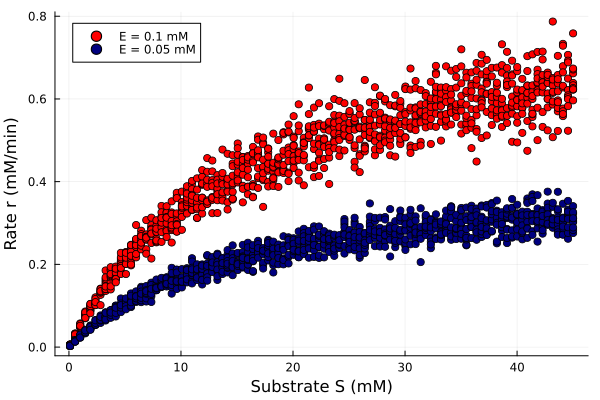

In [8]:
let
    scatter(synthetic_experimental_data[:,1,10],synthetic_experimental_data[:,3,10], c=:red, label="E = $(synthetic_experimental_data[1,2,10]) mM")
    scatter!(synthetic_experimental_data[:,1,5],synthetic_experimental_data[:,3,5], c=:navy, label="E = $(synthetic_experimental_data[1,2,5]) mM")
    xlabel!("Substrate S (mM)", fontsize=18)
    ylabel!("Rate r (mM/min)", fontsize = 18);
end

Expected value of parameters

In [10]:
(μ̂,K̂,β,y,X,E) = let

    enzyme_concentration_index = 10; # which case will we use?
    data = synthetic_experimental_data[:,:,enzyme_concentration_index];
    E = synthetic_experimental_data[1,2,enzyme_concentration_index];
    (number_of_rows, number_of_cols) = size(data);

    Y = zeros(number_of_rows); # output array
    X = ones(number_of_rows,2); # data array
    for i ∈ 1:number_of_rows
        Y[i] = 1/data[i,3]; # 1/r value
        X[i,2] = 1/data[i,1]; # 1/S value
    end

    # compute -
    β = inv(transpose(X)*X)*transpose(X)*Y
    μ̂ = (1/(β[1]*E));
    K̂ = β[2]*μ̂*E;

    # return 
    μ̂,K̂,β,Y,X,E
end;

error model

In [13]:
error_model = let
    residual = y - X*β;
    d = fit_mle(Normal, residual)
    d
end;

samples

In [15]:
parameters = let

    number_of_samples = 10000;
    (number_of_rows, number_of_cols) = size(X);
    β̂ = Array{Float64,2}(undef, number_of_samples, 2);
    parameters = Array{Float64,2}(undef, number_of_samples, 2);
    Z = inv(transpose(X)*X)*transpose(X);
    is_ok_to_stop = false;
    i = 1;
    while (is_ok_to_stop == false)
        
        ϵ = rand(error_model, number_of_rows); # draw from the residual distribution
        tmp = β - Z*ϵ;

        if (tmp[1] > 0)
            β̂[i,1] = tmp[1];
            β̂[i,2] = tmp[2];
            i += 1;
        end
        
        if (i > number_of_samples)
            is_ok_to_stop = true;
        end
    end
    
    # ok, convert the beta samples back to bare parameters
    for i ∈ 1:number_of_samples
        μ = 1/(β̂[i,1]*E);
        parameters[i,1] = μ;
        parameters[i,2] = β̂[i,2]*μ*E;
    end

    parameters
end;

In [16]:
mean(parameters[:,1]), std(parameters[:,1])

(8.055728822660118, 0.3298157788990821)

### Case II: Underdetermind data matrix
Assume the data matrix $\mathbf{X}$ is $\texttt{underdetermined}$, i.e., $n < p$ (more columns than rows), and 
the error vector $\mathbf{\epsilon}\sim\mathcal{N}(\mathbf{0},\sigma^{2}\cdot\mathbf{I})$.
Then, an [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimate of the unknown parameters is the $\textit{smallest}$ parameter vector $\beta$ that satisfies the original equations:
$$
\begin{eqnarray*}
\text{minimize}~& & ||\,\mathbf{\beta}\,|| \\
\text{subject to} & & \mathbf{X}\cdot\mathbf{\beta} = \mathbf{y}
\end{eqnarray*}
$$
The least-norm problem has an analytical estimate for the unknown parameter vector $\hat{\mathbf{\beta}}$ given by:
$$
\begin{equation*}
\hat{\mathbf{\beta}} =\mathbf{X}^{T}\left(\mathbf{X}\mathbf{X}^{T}\right)^{-1}\cdot\mathbf{y} - \mathbf{X}^{T}\left(\mathbf{X}\mathbf{X}^{T}\right)^{-1}\cdot\mathbf{\epsilon}
\end{equation*}
$$
where inverse $\left(\mathbf{X}\mathbf{X}^{T}\right)^{-1}$ must exist to obtain the estimated model parameter vectors $\hat{\mathbf{\beta}}$.

In [18]:
# example goes here

### Case III: Regularized linear regression models
Regularized linear regression models incorporate penalty terms to constrain the size of the coefficient estimates, thereby reducing overfitting and enhancing the model's generalizability to new data. Consider an overdetermined data matrix $\mathbf{X}\in\mathbb{R}^{n\times{p}}$, i.e., the case where $n>p$ (more examples than unknown parameters).

A regularized least squares estimate of the unknown parameters $\mathbf{\beta}$ for an _overdetermined_ system will _minimize_ a loss (objective) function of the form:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} ||~\mathbf{y} - \mathbf{X}\cdot\mathbf{\beta}~||^{2}_{2} + \lambda\cdot||~\mathbf{\beta}~||^{2}_{2}
\end{equation*}
$$
where $||\star||^{2}_{2}$ is the square of the [`p = 2` vector norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm), $\lambda\geq{0}$ denotes a regularization parameter, and $\hat{\mathbf{\beta}}$ denotes the estimated parameter vector. 
The parameters $\hat{\mathbf{\beta}}$ that minimize the $||\star||^{2}_{2}$ loss plus penalty for overdetermined data matrix $\mathbf{X}$ are given by:
$$
\begin{equation*}
\hat{\mathbf{\beta}}_{\lambda} = \left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}\mathbf{X}^{T}\mathbf{y} - \left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}\mathbf{X}^{T}\mathbf{\epsilon}
\end{equation*}
$$
The matrix $\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}$ is the $\texttt{regularized normal matrix}$, while $\mathbf{X}^{T}\mathbf{y}$ is the $\texttt{moment vector}$. The inverse $\left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}$ must exist to obtain the estimated parameter vector $\hat{\mathbf{\beta}}_{\lambda}$.

In [20]:
# example goes here

## Linear regression models for classification tasks
Linear regression can be adapted for classification tasks by transforming the continuous output of the linear regression model directly to a class designation, e.g., $\sigma:\mathbb{R}\rightarrow\{-1,+1\}$ or into a probability using an output function $\sigma:\mathbb{R}\rightarrow\mathbb{R}$ and applying a threshold to categorize predictions into discrete classes. Let's take a look at two examples of these strategies:

* [The Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) is a simple yet powerful algorithm used in machine learning for binary classification tasks. It operates by _incrementally_ learning a linear decision boundary (linear regression model) that separates two classes based on input features by directly mapping the continuous output to a class such as $\sigma:\mathbb{R}\rightarrow\{-1,+1\}$, where the output function is $\sigma(\star) = \text{sign}(\star)$.
* [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression#) is a statistical method used in machine learning for binary classification tasks using the [logistics function](https://en.wikipedia.org/wiki/Logistic_function) as the transformation function. Applying the logistic function transforms the output of a linear regression model into a probability, enabling effective decision-making in various applications.

### Perceptron
[The Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) takes the (scalar) output of a linear regression model $y_{i}\in\mathbb{R}$ and then transforms it using the $\sigma(\star) = \text{sign}(\star)$ function to a discrete set of values representing categories, e.g., $\sigma:\mathbb{R}\rightarrow\{-1,1\}$ in the binary classification case. 
* Suppose there exists a data set.
$\mathcal{D} = \left\{(\mathbf{x}_{1},y_{1}),\dotsc,(\mathbf{x}_{m},y_{m})\right\}$ with $m$ _labeled_ examples, where each example $1,2,\dots,m$ has been labeled by an expert, i.e., a human to be in a category $\hat{y}_{i}\in\{-1,1\}$, given the feature vector $\mathbf{x}_{i}\in\mathbb{R}^{n}$. 
* The Perceptron _incrementally_ learns a linear decision boundary between _two_ classes of possible objects (binary classification) in $\mathcal{D}$ by repeatedly processing the data. During each pass, a regression parameter vector $\mathbf{\beta}$ is updated until it makes no more than a specified number of mistakes. 

The Perceptron computes the label $\hat{y}_{i}$ for feature vector $\mathbf{x}_{i}$ using the $\sigma(\star) = \text{sign}(\star)$ function:
$$
\begin{equation*}
    \hat{y}_{i} = \text{sign}\left(\mathbf{x}_{i}^{T}\cdot\beta\right)
\end{equation*}
$$
where $\beta=\left(w_{1},\dots,w_{n}, b\right)$ is a column vector of (unknown) weight parameters $w_{j}\in\mathbb{R}$ corresponding to the importance of feature $j$ and a   bias parameter $b\in\mathbb{R}$, the features $\mathbf{x}^{T}_{i}=\left(x^{(i)}_{1},\dots,x^{(i)}_{n}, 1\right)$ is the $n+1$-dimensional feature (row) vector (features augmented with bias term), and $\text{sign}(z)$ is the $\texttt{sign}$ function:
$$
\begin{equation*}
    \text{sign}(z) = 
    \begin{cases}
        1 & \text{if}~z\geq{0}\\
        -1 & \text{if}~z<0
    \end{cases}
\end{equation*}
$$
__Hypothesis__: If data set $\mathcal{D}$ is linearly separable, the Perceptron will _incrementally_ learn a separating hyperplane in a finite number of passes through the data set $\mathcal{D}$. However, if the data set $\mathcal{D}$ is not linearly separable, the Perceptron may not converge. Check out a [perceptron pseudo-code here!](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/figs/pcode-perceptron.pdf)